In [1]:
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import torch

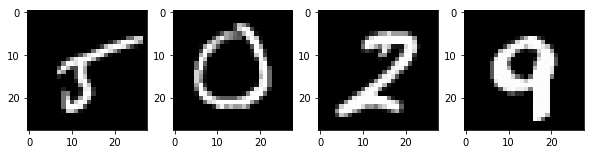

In [4]:
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(43)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.0, 1.0)
])

train_dataset = torchvision.datasets.MNIST(root="./mnist", download=True, transform=transform, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root="./mnist", download=True, transform=transform, train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.figure(figsize=(10, 7.5))
n_col = 4
for i in range(n_col):
    ax = plt.subplot(3, n_col, i + 1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')

plt.show()

In [5]:
from tqdm import tqdm

torch.manual_seed(43)

INPUT_CH  = images.shape[1]
HIDDEN1_CH = 24
HIDDEN2_CH = 36
LATENT_DIM = 8

class CNNAutoEncoder(torch.nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(INPUT_CH, HIDDEN1_CH, 3, stride=2),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(HIDDEN1_CH, HIDDEN2_CH, 3, stride=2, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(HIDDEN2_CH, LATENT_DIM, 6, bias=False),
            torch.nn.Sigmoid(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.LayerNorm((LATENT_DIM, 1, 1)),
            
            torch.nn.ConvTranspose2d(LATENT_DIM, HIDDEN2_CH, 6, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(HIDDEN2_CH, HIDDEN2_CH, 3, stride=2, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(HIDDEN2_CH, HIDDEN1_CH, 4, stride=2, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(HIDDEN1_CH, INPUT_CH, 1, bias=False),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

model = CNNAutoEncoder()

loss_fn = torch.nn.MSELoss(reduction='mean')

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 5
train_loss_hist = []
test_loss_hist = []
for e in range(epochs):
    for i, batch in tqdm(enumerate(train_loader)):
        images, labels = batch
        _, decoded = model(images)
        loss = loss_fn(decoded, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    train_loss_hist.append(loss)
    with torch.no_grad():
        count = 0
        total_loss = 0
        for i, batch in enumerate(test_loader):
            images, labels = batch
            _, decoded = model(images)
            loss = loss_fn(decoded, images)
            count += 1
            total_loss += loss
        test_loss_hist.append(total_loss/count)

15000it [02:46, 89.98it/s] 
15000it [02:41, 92.91it/s] 
15000it [02:32, 98.10it/s] 
15000it [02:21, 105.65it/s]
15000it [02:27, 101.86it/s]


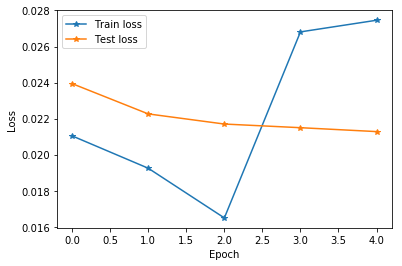

In [6]:
train_loss_hist = np.asarray(train_loss_hist)
test_loss_hist = np.asarray(test_loss_hist)
plt.plot(train_loss_hist, '-*', label='Train loss')
plt.plot(test_loss_hist, '-*', label='Test loss')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

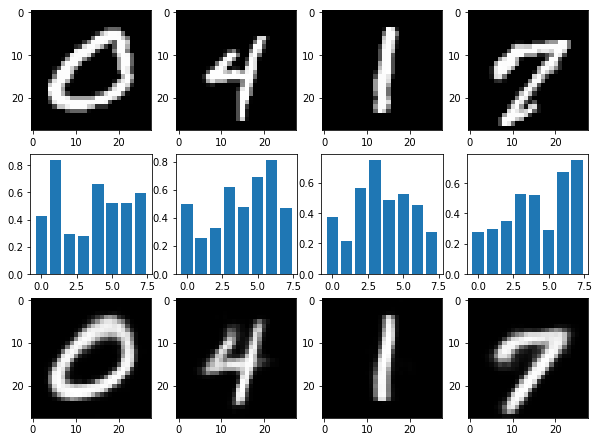

In [7]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

with torch.no_grad():
    encoded, decoded = model(images)

plt.figure(figsize=(10, 7.5))
n_col = 4
for i in range(n_col):
    ax = plt.subplot(3, n_col, i + 1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    ax = plt.subplot(3, n_col, i + 1 + n_col)
    plt.bar(np.arange(encoded[i].shape[0]), encoded[i].flatten())
    ax = plt.subplot(3, n_col, i + 1 + n_col * 2)
    plt.imshow(decoded[i].reshape(28,28), cmap='gray')

plt.show()

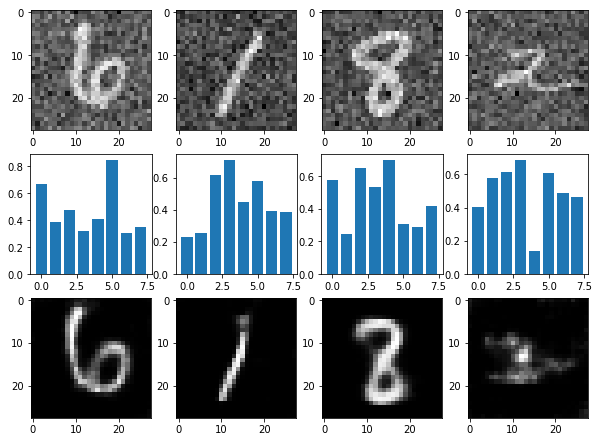

In [8]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
noise_level = 0.2
images = (images + torch.randn(images.shape) * noise_level) / (1.0 + noise_level)

with torch.no_grad():
    encoded, decoded = model(images)

plt.figure(figsize=(10, 7.5))
n_col = 4
for i in range(n_col):
    ax = plt.subplot(3, n_col, i + 1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')
    ax = plt.subplot(3, n_col, i + 1 + n_col)
    plt.bar(np.arange(encoded[i].shape[0]), encoded[i].flatten())
    ax = plt.subplot(3, n_col, i + 1 + n_col * 2)
    plt.imshow(decoded[i].reshape(28,28), cmap='gray')

plt.show()